Modification of the CellOracle tutorial https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/04_Network_analysis/Network_analysis_with_Paul_etal_2015_data.ipynb

# Overview 

This notebook describes how to construct GRN models in CellOracle. 
Please read our paper first to know about the CellOracle's GRN modeling algorithm.

Last update: 4/13/2022, Kenji Kamimoto

### Notebook file
Notebook file is available on CellOracle's GitHub page.
https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/04_Network_analysis/Network_analysis_with_Paul_etal_2015_data.ipynb


### Data
CellOracle uses two types of input data during the GRN model construction.

- **Input data 1: scRNA-seq data**. Please look at the previous section to learn about the scRNA-seq data preprocessing. https://morris-lab.github.io/CellOracle.documentation/tutorials/scrnaprocess.html


- **Input data 2: Base-GRN**. The base GRN represents the TF-target gene connections. The data structure is a binary 2D matrix or linklist. Please look at our paper to know the concept of base GRN.

 - CellOracle typically uses a base GRN constructed from scATAC-seq data. If you would like to create a custom base GRN using your scATAC-seq data, please refer to the following notebook. https://morris-lab.github.io/CellOracle.documentation/tutorials/base_grn.html
 - If you do not have any sample-specific scATAC-seq data that correspond to the same/similar cell type of the scRNA-seq data, please use pre-built base GRN.  
 - We provide multiple options for pre-built base GRN. For analyses in mice, we recommend using a base GRN built from the mouse sciATAC-seq Atlas dataset. It includes various tissues and various cell types. Another option is using base GRN constructed from promoter database. We provide promoter base GRNs for ten species.

### What you can do
After constructing the CellOracle GRN models, you can do two analyses.

1. **in silico TF perturbation analysis**. CellOracle uses the GRN models to simulate cell identity shifts in response to TF perturbation. For this analysis, you must first construct your GRN models in this notebook.

2. **Network analysis**. You can analyze the GRN models using graph theory. We provide several functions. 
 - CellOracle construct cluster-wise GRN models. You can compare the GRN model structure between clusters, which allows you to investigate the cell type-specific GRN configurations and explore structual changes as GRNs are rewired along the cell differentiation trajectory.
 - You can also export the network models and analyze the GRN models using external packages or softwares. 
 
### Custom data classes / objects

In this notebook, CellOracle uses two custom classes, `Oracle` and `Links`.

- `Oracle` is the main class in the CellOracle package. It is responsible for almost all the GRN model construction and TF perturbation simulation. `Oracle` does the following calculations sequentially.
 1. Import scRNA-sequence data. Please refer to the data preparation notebooks to learn about data preparation procedures.
 2. Import base GRN data.
 3. scRNA-seq data processing. 
 4. GRN model construction.
 5. in silico petrurbation. We will describe how to do this in the following notebook.

- `Links` is a class to store GRN data. It also conteins many functions for network analysis and visualization.


# 0. Import libraries

In [1]:
# 0. Import

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


In [2]:
import celloracle as co
co.__version__

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


'0.12.0'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# 1. Load data
## 1.1. Load processed gene expression data (anndata)

Please refer to the previous notebook to learn about scRNA-seq data processing.
https://morris-lab.github.io/CellOracle.documentation/tutorials/scrnaprocess.html

The scRNA-seq data must be in the anndata format.

> **This CellOracle tutorial notebook assumes the user has basic knowledge and experience with scRNA-seq analysis using Scanpy and Anndata.** This notebook is not intended to be an introduction to Scanpy or Anndata. 
> If you are not familiar with them, please learn them using the documentation and tutorials for Scanpy (https://scanpy.readthedocs.io/en/stable/) and annata (https://anndata.readthedocs.io/en/stable/).



In [4]:
adata = sc.read_h5ad("celloracle_scRNA-seq.h5ad")
adata

AnnData object with n_obs × n_vars = 14486 × 2304
    obs: 'louvain', 'louvain_annot', 'cell_type'
    var: 'gene_ids'
    obsm: 'X_pca'
    layers: 'raw_count'

## 1.2. Load base-GRN data. 
To infer cluster-specific GRNs, CellOracle requires a base GRN. 
- There are several ways to make a base GRN. We can typically generate base GRN from scATAC-seq data or bulk ATAC-seq data. Please refer to the first step of the tutorial to learn more about this process. https://morris-lab.github.io/CellOracle.documentation/tutorials/base_grn.html


- If you do not have your scATAC-seq data, you can use one of the built-in base GRNs options below. 

- Base GRNs made from mouse sci-ATAC-seq atlas : The built-in base GRN was made from various tissue/cell-types found in the atlas (http://atlas.gs.washington.edu/mouse-atac/). We recommend using this for mouse scRNA-seq data. Please load this data as follows.

 `base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()`


- Promoter base GRN: We also provide base GRN made from promoter DNA-sequences for ten species. You can load this data as follows.

 - e.g. for Human: `base_GRN = co.data.load_human_promoter_base_GRN()`



In [6]:
base_GRN = pd.read_csv("celloracle_base_GRN.txt", sep='\t')
base_GRN

,peak_id,gene_short_name,Arid3b,Arid3a,Arid5a,Arid3c,Arid2,Setbp1,Ahctf1,Hmga2,...,Nfe2l3,Wt1,E4f1,Klf16,Dmrta2,Foxm1,NEWGENE_1310011,Mef2b,Smad5,LOC103691556
0,chr1_80374_80874,Vom2r2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr1_241723_242223,Vom2r4,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,chr1_1401970_1402470,Rrlt,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chr1_1402548_1403048,Rrlt,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,chr1_2078486_2078986,Lrp11,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52886,chrX_152174548_152175048,Fam3a,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
52887,chrX_152175067_152175567,Fam3a,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52888,chrX_152220054_152220554,G6pd,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52889,chrX_152220661_152221161,G6pd,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


# 2. Make Oracle object

We will use an Oracle object during the data preprocessing and GRN inference steps. Using its internal functions, the Oracle object computes and stores all of the necessary information for these calculations. To begin, we will instantiate a new Oracle object and input our gene expression data (anndata) and TF info (base GRN).

In [7]:
# Instantiate Oracle object
oracle = co.Oracle()

## 2.1. load gene expression data into oracle object.

For the CellOracle analysis, your anndata should include (1) gene expression counts, (2) clustering information, and (3) trajectory (dimensional reduction embedding) data. Please refer to a previous notebook for more information on anndata preprocessing.


When you load the scRNA-seq data, please enter **the name of the clustering data** and **the name of the dimensionality reduction.**
 - The clustering data should be to be stored in the `obs` the attribute of anndata. 
  > You can check it using the following command.
  >
  > `adata.obs.columns`
  
 - Dimensional reduction data is stored in the `obsm` the attribute of anndata. 
  > You can check it with the following command.
  > 
  > `adata.obsm.keys()`
  


In [8]:
# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['louvain', 'louvain_annot', 'cell_type']
Dimensional reduction:  ['X_pca']


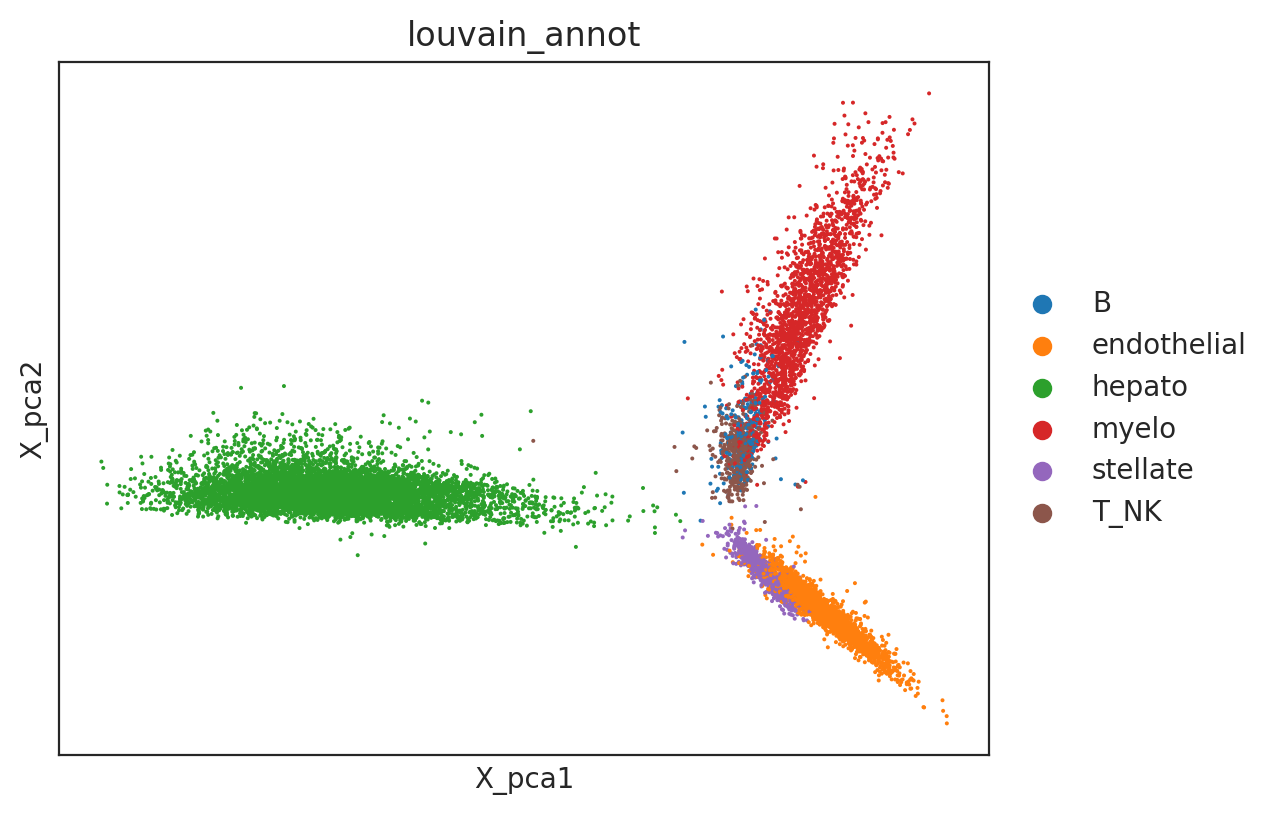

In [9]:
# In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
adata.X = adata.layers["raw_count"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="louvain_annot",
                                   embedding_name="X_pca")

## 2.2. Load base-GRN data into oracle object

In [10]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

# Alternatively, if you saved the informmation as a dictionary, you can use the code below.
# oracle.import_TF_data(TFdict=TFinfo_dictionary)

# 3. KNN imputation
CellOracle uses the same strategy as velocyto for visualizing cell transitions. This process requires KNN imputation in advance.

For the KNN imputation, we first need to calculate and select PCs.

## 3.1. PCA

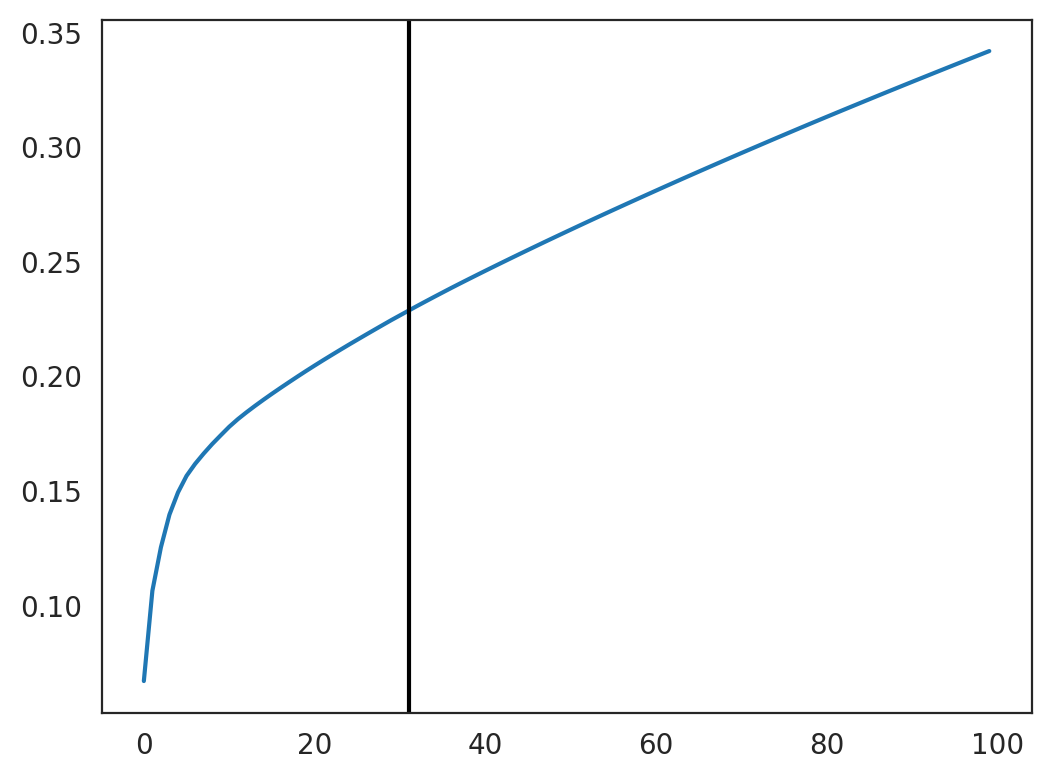

31


In [11]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

## 3.2. KNN imputation

Estimate the optimal number of nearest neighbors for KNN imputation.

In [12]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :14486


In [13]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :362


In [14]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

In [29]:
# Save oracle object.
oracle.to_hdf5("celloracle.oracle")

In [30]:
# Load file.
oracle = co.load_hdf5("celloracle.oracle")

# 5. GRN calculation
The next step constructs a cluster-specific GRN for all clusters.

- You can calculate GRNs with the `get_links` function, and it will return the results as a `Links` object.
The `Links` object stores the inferred GRNs and the corresponding metadata. Most network structure analysis is performed with the `Links` object.

- A GRN will be calculated for each cluster/sub-group. In the example below, we construct GRN for each unit of the "louvain_annot" clustering.



## 5.1. Get GRNs

In [15]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit="louvain_annot", alpha=10,
                         verbose_level=10)

  0%|          | 0/6 [00:00<?, ?it/s]

Inferring GRN for B...


  0%|          | 0/1641 [00:00<?, ?it/s]

Inferring GRN for T_NK...


  0%|          | 0/1641 [00:00<?, ?it/s]

Inferring GRN for endothelial...


  0%|          | 0/1641 [00:00<?, ?it/s]

Inferring GRN for hepato...


  0%|          | 0/1641 [00:00<?, ?it/s]

Inferring GRN for myelo...


  0%|          | 0/1641 [00:00<?, ?it/s]

Inferring GRN for stellate...


  0%|          | 0/1641 [00:00<?, ?it/s]

CPU times: user 5min 45s, sys: 17.2 s, total: 6min 3s
Wall time: 8min 9s


## 5.2. (Optional) Export GRNs

Although CellOracle has many functions for network analysis, you can export and analyze GRNs using another software if you chose.
The raw GRN data is stored as a dictionary of dataframe in the `links_dict` attribute.

For example, you can get the GRN for the "Ery_0" cluster with the following commands.

In [16]:
links.links_dict.keys()

dict_keys(['B', 'T_NK', 'endothelial', 'hepato', 'myelo', 'stellate'])

In [17]:
links.links_dict["hepato"]

,source,target,coef_mean,coef_abs,p,-logp
0,Mycs,Abcb6,0.022063,0.022063,1.827544e-14,13.738132
1,Maz,Abcb6,0.004366,0.004366,2.010552e-03,2.696685
2,Fezf2,Abcb6,-0.007502,0.007502,5.006739e-06,5.300445
3,Nhlh1,Abcb6,0.010982,0.010982,2.689098e-08,7.570393
4,Necab3,Abcb6,0.009669,0.009669,1.249502e-06,5.903263
...,...,...,...,...,...,...
68596,Rfx6,Zswim7,-0.035317,0.035317,3.956041e-06,5.402739
68597,Foxb2,Zswim7,-0.030654,0.030654,1.144872e-09,8.941243
68598,Gli1,Zswim7,-0.021099,0.021099,7.946992e-06,5.099797
68599,Nr1h2,Zswim7,-0.012564,0.012564,5.623429e-09,8.249999


You can export the file as follows.

In [23]:
# Set cluster name
cluster = "hepato"

# Save as csv
links.links_dict[cluster].to_csv(f"raw_GRN_for_{cluster}.csv")